In [ ]:
!pip install rasterio
import rasterio 
import time
import rasterio.plot
from rasterio.windows import Window
from rasterio.plot import show
import pandas as pd
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
import tables
project_id = 'omega-granite-294710'
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

AccessDeniedException: 403 57341090791-compute@developer.gserviceaccount.com does not have storage.buckets.list access to the Google Cloud project.


In [ ]:
# %cd /data/philippines/original/
# !ls
!gdalsrsinfo -o xml ./1990.tif 

## Load original and matt hansen data from bucket.

In [ ]:
"""
Load matt hansen data from bucket.
"""
# !gsutil cp gs://data-new-phil/phil/0000000000-0000000000.tif /data/philippines/matt_hansen.tif
# clip matt_hansen -> matt_hansen_clipped

years = range(2000, 2021, 1)
for year in years:
  bash_hack_year = str(year) # "1" added just as proxy, because first character was not being read
  # !gsutil cp gs://data-new-phil/gearth_year_"$bash_hack_year"_/0000000000-0000000000.tif /data/philippines/original/"$bash_hack_year".tif

In [ ]:
for year in range(2000,2021):
  src = rasterio.open('/data/philippines/original/{}.tif'.format(year))
  X = src.read()
  isnull=0
  for i in range(0, 11):
    isnull=np.isnan(X[i,:,:]).sum()
    print(f"{year = }, band {i} : {isnull}")

  print(year,":",isnull,"\tShape:",X.shape)
  src.close()
  del X

In [ ]:
data = rasterio.open('/data/philippines/original/2000.tif')
show(data)

### Fix Nans at 30m resolution.

In [ ]:
for year in range(2000, 2001):
  start_time = time.perf_counter()
  print(f"Starting with {year = }")
  src = rasterio.open('/data/philippines/original/{}.tif'.format(year))
  profile = src.profile

  for band in range(1,12):
    curr = pd.DataFrame(src.read(band))
    curr = curr.fillna(value = curr.mean(skipna = True))
    curr = curr.fillna(value = 0)
    if(np.any(np.isnan(curr)) == True):
      print(f"Nan entry at {year = }, {band = }")

    with rasterio.open('/data/philippines/corrected/{}.tif'.format(year), 'w', **profile) as dst:
        dst.write(curr[:][:].astype(rasterio.float64), band)
    
    del curr
  
  src.close()

Starting with year = 2000


Nan check : False
(11, 7168, 7168)


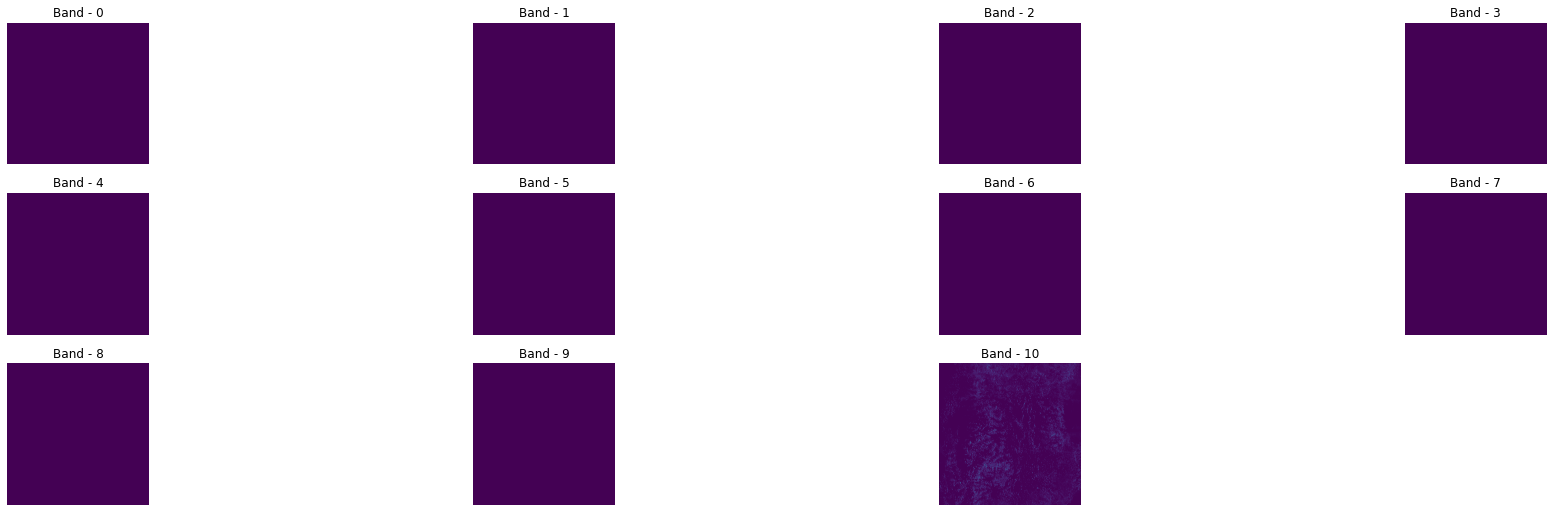

In [ ]:
# ran now
year = 2000
src = rasterio.open('/data/philippines/corrected/{}.tif'.format(year))
X = np.asarray(src.read())
print(f"Nan check : {np.any(np.isnan(X))}")
print(X.shape)

# catch
fig = plt.figure(figsize = (32, 12))
for i in range(0, 11):
  fig.add_subplot(4, 4, i+1)
  plt.imshow(X[i,:,:], vmin=np.min(X[i,:,:]), vmax=np.max(X[i,:,:]))
  plt.axis('off')
  plt.title(f'Band - {i}')
del X
src.close()

In [ ]:
for year in range(2000,2021):
  src = rasterio.open('/data/philippines/corrected/{}.tif'.format(year))
  X = src.read()
  isnull=0
  for i in range(0, 11):
    isnull=np.isnan(X[i,:,:]).sum()
    print(f"{year = }, band {i} : {isnull}")

  print(year,":",isnull,"\tShape:",X.shape)
  src.close()
  del X

### Check for Nans in corrected files.

In [ ]:
for year in range(2000,2021):
  src = rasterio.open('/data/philippines/corrected/{}.tif'.format(year))
  X = src.read()
  isnull=0
  for i in range(0, 11):
    isnull=np.isnan(X[i,:,:]).sum()
    print(f"{year = }, band {i} : {isnull}")

  print(year,":",isnull,"\tShape:",X.shape)
  src.close()
  del X

## Create matt_hansen targets

### Create single .tif file for year 2000 -> matt/2000.tif

In [ ]:
'''
Make matt hansen 2000.tif, used to create tif for next years.
'''
df=gdal.Open("/data/philippines/matt_hansen_clipped.tif")
geotransform = df.GetGeoTransform()
projection = df.GetProjection()
cover=df.GetRasterBand(1)
x_len = cover.XSize
y_len = cover.YSize

cover_year=cover.ReadAsArray()
driver = gdal.GetDriverByName('GTiff')
new_tiff = driver.Create("/data/philippines/matt/"+str(2000)+".tif",x_len,y_len,1,gdal.GDT_Float64)
new_tiff.SetGeoTransform(geotransform)
new_tiff.SetProjection(projection)
new_tiff.GetRasterBand(1).WriteArray(cover_year)
new_tiff.FlushCache() #Saves to disk
new_tiff = None #closes the file

### Create remaining matt_{}.tif files

In [ ]:
# inspired from here https://gis.stackexchange.com/a/285685
for year in range(1,21):
  df=gdal.Open("/data/philippines/matt/"+str(1999+year)+".tif")
  geotransform = df.GetGeoTransform()
  projection = df.GetProjection()
  cover=df.GetRasterBand(1)
  cover_year=cover.ReadAsArray()

  df=gdal.Open("/data/philippines/matt_hansen_clipped.tif")
  band=df.GetRasterBand(4)
  loss_year=band.ReadAsArray()
  x_len=band.XSize
  y_len=band.YSize

  band=None
  df=None
  
  cover_year[loss_year==year]=0
  cover_year=cover_year.astype("float64")
  driver = gdal.GetDriverByName('GTiff')
  new_tiff = driver.Create("/data/philippines/matt/"+str(2000+year)+".tif",x_len,y_len,1,gdal.GDT_Float64)
  new_tiff.SetGeoTransform(geotransform)
  new_tiff.SetProjection(projection)
  new_tiff.GetRasterBand(1).WriteArray(cover_year)
  new_tiff.FlushCache() #Saves to disk
  new_tiff = None #closes the file
  print("Created tiff for year: ",year+2000)

In [ ]:
root = '/data/philippines/matt/'
src = gdal.Open(root + "2001.tif")
ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
lry = uly + (src.RasterYSize * yres)
lrx = ulx + (src.RasterXSize * xres)
print(src.GetGeoTransform())

(120.420691, 0.0002694945870535715, 0.0, 18.3930054, 0.0, -0.0002694945731026785)


### Remove Nan from matt files.

In [ ]:
for year in range(2000, 2021):
  start_time = time.perf_counter()
  print(f"Starting with {year = }")
  src = rasterio.open('/data/philippines/matt/{}.tif'.format(year))

  for band in range(1,2):
    curr = pd.DataFrame(src.read(band))
    curr = curr.fillna(value = curr.mean(skipna = True))
    curr = curr.fillna(value = 0)
    if(np.any(np.isnan(curr)) == True):
      print(f"Nan entry at {year = }, {band = }")

    with rasterio.Env():
        profile = src.profile
        with rasterio.open('/data/philippines/matt_corrected/{}.tif'.format(year), 'w', **profile) as dst:
          dst.write(curr[:][:].astype(rasterio.float64), band)
    
    del curr
  
  src.close()

# Changing resolution of data which is relevant

Google Earth Engine should have had given us higher resolution too, but it would have been split into multiple files again, therefore I just start off with a patch and then write the code for changing the resolution

In [ ]:
from rasterio.enums import Resampling
def resample_raster(input_path, output_path, targetPixelSizeX = 0.003, targetPixelSizeY = 0.003):
    raster = rasterio.open(input_path)
    t = raster.transform

    pixelSizeX = t[0]
    pixelSizeY =-t[4]
    print(pixelSizeX, pixelSizeY)
    scalingFactorX = (targetPixelSizeX / pixelSizeX)
    scalingFactorY = (targetPixelSizeY / pixelSizeY)

    sizeX = raster.shape[0]
    sizeY = raster.shape[1]

    targetSizeX = int(sizeX / scalingFactorX)
    targetSizeY = int(sizeY / scalingFactorY)
    print(targetSizeX, targetSizeY)

    scale = scalingFactorX
    assert (scalingFactorX == scalingFactorY)

    # rescale the metadata
    transform = rasterio.Affine(t.a * scale, t.b, t.c, t.d, t.e * scale, t.f)  # <== multiplication
    height = int(raster.height // scale)                              # <== division
    width = int(raster.width // scale)
    print(height, width)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width, crs=raster.crs)
    print(profile)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(int(raster.count), int(height), int(width)),
            resampling=Resampling.cubic)

    with rasterio.open(output_path,'w', **profile) as dst:
        dst.write(data)

    print("Completed rewriting, now checking values:")
    resampled = rasterio.open(output_path)
    print('Orig dims: {}, New dims: {}'.format(raster.shape, resampled.shape))

from rasterio.enums import Resampling

def resampleRasterforNonSquare(input_path, output_path, targetPixelSizeX = 0.003, targetPixelSizeY = 0.003):
    raster = rasterio.open(input_path)
    t = raster.transform

    pixelSizeX = t[0]
    pixelSizeY =-t[4]
    print(pixelSizeX, pixelSizeY)
    scalingFactorX = (targetPixelSizeX / pixelSizeX)
    scalingFactorY = (targetPixelSizeY / pixelSizeY)

    sizeX = raster.shape[0]
    sizeY = raster.shape[1]

    targetSizeX = int(sizeX / scalingFactorX)
    targetSizeY = int(sizeY / scalingFactorY)
    print(targetSizeX, targetSizeY)

    scale = scalingFactorX

    # assert (scalingFactorX == scalingFactorY)

    # rescale the metadata
    transform = rasterio.Affine(t.a * scalingFactorX, t.b, t.c, t.d, t.e * scalingFactorY, t.f)  # <== multiplication
    height = int(raster.height // scalingFactorX)                              # <== division
    width = int(raster.width // scalingFactorY)
    print(height, width)

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width, crs=raster.crs)
    print(profile)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(int(raster.count), int(height), int(width)),
            resampling=Resampling.cubic)

    with rasterio.open(output_path,'w', **profile) as dst:
        dst.write(data)

    print("Completed rewriting, now checking values:")
    resampled = rasterio.open(output_path)
    print('Orig dims: {}, New dims: {}'.format(raster.shape, resampled.shape))

### Resample input data

In [ ]:
# Doing for the landsat Data
import glob
landsat_tifs = glob.glob("/data/philippines/corrected/*.tif")
print(landsat_tifs)
for file in landsat_tifs:
  output_path = file[:-4] + "_resampled.tif"
  print(output_path)
  resample_raster(file, output_path, targetPixelSizeX = 0.003, targetPixelSizeY = 0.003)

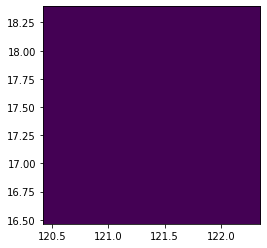

<AxesSubplot:>

In [ ]:
data = rasterio.open('/data/philippines/corrected/2001_resampled.tif')
show(data)

### Resample targets

In [ ]:
for year in range(2000, 2021):
  file_path = f'/data/philippines/matt_corrected/{year}.tif'
  output_path = f'/data/philippines/matt_corrected/{year}_resampled.tif'
  resampleRasterforNonSquare(file_path, output_path)

# Creating H5 timeseries

In [ ]:
import numpy as np
def make_ts(spectral_data, start, end, look_back):
  X = []
  for i in range(start+look_back, end):
    X_i = []
    for t in range(look_back):
      X_i.append(spectral_data[i-start-look_back+t])
    X.append(np.array(X_i))
  return np.array(X)

root = '/data/philippines/'

def make_dataset_and_save(filename, left_x, right_x, top_y, bottom_y, overlap, picture_size, look_back):
  year_targets = {}
  for year in range(2001, 2021):
    print("Opening", year)
    year_targets[year] = rasterio.open(root + "matt_corrected/" + str(year) + "_resampled.tif")

  geo_topleft_x, geo_topleft_y, geo_bottomright_x, geo_bottomright_y = 0, 0, 0, 0
  with rasterio.open(root + "corrected/2001.tif") as src:
     geo_topleft_x, geo_topleft_y = rasterio.transform.xy(src.transform, top_y, left_x)
     geo_bottomright_x, geo_bottomright_y = rasterio.transform.xy(src.transform, bottom_y, right_x)

  with rasterio.open(root + '/matt_corrected/2001_resampled.tif') as src: #As the middle file
      target_topleft_py, target_topleft_px = src.index(geo_topleft_x, geo_topleft_y)
      target_bottomright_py, target_bottomright_px = src.index(geo_bottomright_x, geo_bottomright_y)
  
  targets_file = rasterio.open(root + '/matt_corrected/2001_resampled.tif')
  shortlisted_coords = []

  for i in range(0, right_x-int(picture_size) + 1, int(picture_size*overlap)): #Loops in spectral data coordinates
    for j in range(0, bottom_y-int(picture_size) + 1,  int(picture_size*overlap)):
      y = targets_file.read(window=Window(target_topleft_px+i, target_topleft_py+j, picture_size, picture_size))
      y = y/100
      if np.sum(y) > 0.0:
        shortlisted_coords.append([i, j])
        
  targets_file.close()

  print(f"{shortlisted_coords = }")
  year_files = {}
  for year in range(2001, 2021):
    # print("Opening", year)
    year_files[year] = rasterio.open(root + "corrected/" + str(year) + "_resampled.tif")

  for coords in shortlisted_coords:
    offset_x = coords[0]
    offset_y = coords[1]

    print(f"Starting : {offset_x = }, {offset_y = }")

    spectral_data = []
    target_data = []

    for year in range(2001, 2021):
      # print("Appending", year)
      spectral_data.append(year_files[year].read(window=Window(offset_x, offset_y, picture_size, picture_size)))

    for year in range(2001+look_back, 2021):
      # print("Generating targets", year)
      target_data.append(year_targets[year].read(window=Window(target_topleft_px+offset_x, target_topleft_py+offset_y, picture_size, picture_size)))

    print("Generating time series")

    X_thispatch = make_ts(spectral_data, 2001, 2021, look_back)
    print(X_thispatch.shape)

    y_thispatch = np.array(target_data)
    print(y_thispatch.shape)

    f_X = tables.open_file(filename_X, mode='a')
    f_y = tables.open_file(filename_y, mode='a')

    print("Writing patches...")
    for i in range(X_thispatch.shape[0]):
      f_X.root.data.append(np.reshape(X_thispatch[i], (1, look_back, num_channels, picture_size, picture_size)))
      f_y.root.data.append(np.reshape(y_thispatch[i], (1, 1, picture_size, picture_size)))
    f_X.close()
    f_y.close()
    print("Patches written")

  f_X = tables.open_file(filename_X, mode='a')
  f_y = tables.open_file(filename_y, mode='a')

  print(f_X.root.data.shape)
  print(f_y.root.data.shape)
  f_X.close()
  f_y.close()

In [ ]:
!pip install rasterio tables
import tables
tables.file._open_files.close_all()
filename_X = '/data/philippines/h5/X.h5'
filename_y = '/data/philippines/h5/y.h5'
num_channels = 11
look_back = 5
picture_size = 32
f_X = tables.open_file(filename_X, mode='w')
f_y = tables.open_file(filename_y, mode='w')
atom_X = tables.Float64Atom()
array_X = f_X.create_earray(f_X.root, 'data', atom_X, (0, look_back, num_channels, picture_size, picture_size))
atom_y = tables.Int8Atom()
array_y = f_y.create_earray(f_y.root, 'data', atom_y, (0, 1, picture_size, picture_size))
f_X.close()
f_y.close()

In [ ]:
filename = ""

# image size has reduced to 643
make_dataset_and_save(filename, 0, 643, 0, 643, 0.9, picture_size, look_back)

Opening 2001
Opening 2002
Opening 2003
Opening 2004
Opening 2005
Opening 2006
Opening 2007
Opening 2008
Opening 2009
Opening 2010
Opening 2011
Opening 2012
Opening 2013
Opening 2014
Opening 2015
Opening 2016
Opening 2017
Opening 2018
Opening 2019
Opening 2020
shortlisted_coords = [[0, 84], [0, 112], [0, 140], [0, 168], [0, 196], [0, 224], [0, 252], [0, 280], [0, 308], [0, 336], [0, 364], [0, 392], [0, 420], [0, 448], [0, 476], [0, 504], [0, 532], [0, 560], [0, 588], [28, 0], [28, 28], [28, 56], [28, 84], [28, 112], [28, 140], [28, 168], [28, 196], [28, 224], [28, 252], [28, 280], [28, 308], [28, 336], [28, 364], [28, 392], [28, 420], [28, 448], [28, 476], [28, 504], [28, 532], [28, 560], [28, 588], [56, 0], [56, 28], [56, 56], [56, 84], [56, 112], [56, 140], [56, 168], [56, 196], [56, 224], [56, 252], [56, 280], [56, 308], [56, 336], [56, 364], [56, 392], [56, 420], [56, 448], [56, 476], [56, 504], [56, 532], [56, 560], [56, 588], [84, 0], [84, 28], [84, 56], [84, 84], [84, 112], [84, 

## Verifying if altered Tiff is correct

Verifying for the year 2007

In [ ]:
#testing on 2007
src = rasterio.open('/data/philippines/corrected/{}_resampled.tif'.format(2007))
X = src.read()

print("## Year: 2007 Corrected" + "\n")
print("Band \t Max \t Min \t Mean \t Std \t #Nan \n")
for i in range(0, 11):
    print(i, "\t", X[i,:,:].max(), "\t",  X[i,:,:].min(), "\t",  X[i,:,:].mean(), "\t", X[i,:,:].std(), "\t",  np.isnan(X[i,:,:]).sum())

src.close()
del X

print("\n## Year: 2007 Old" + "\n")
print("Band \t Max \t Min \t Mean \t Std \t #Nan \n")
for i in range(0, 11):
    print(i, "\t", X_old[i,:,:].max(),"\t",  X_old[i,:,:].min(),"\t",  X_old[i,:,:].mean(),"\t",  X_old[i,:,:].std() ,"\t", np.isnan(X_old[i,:,:]).sum())

src_old.close()
del X_old

Nan check : False
(11, 643, 643)


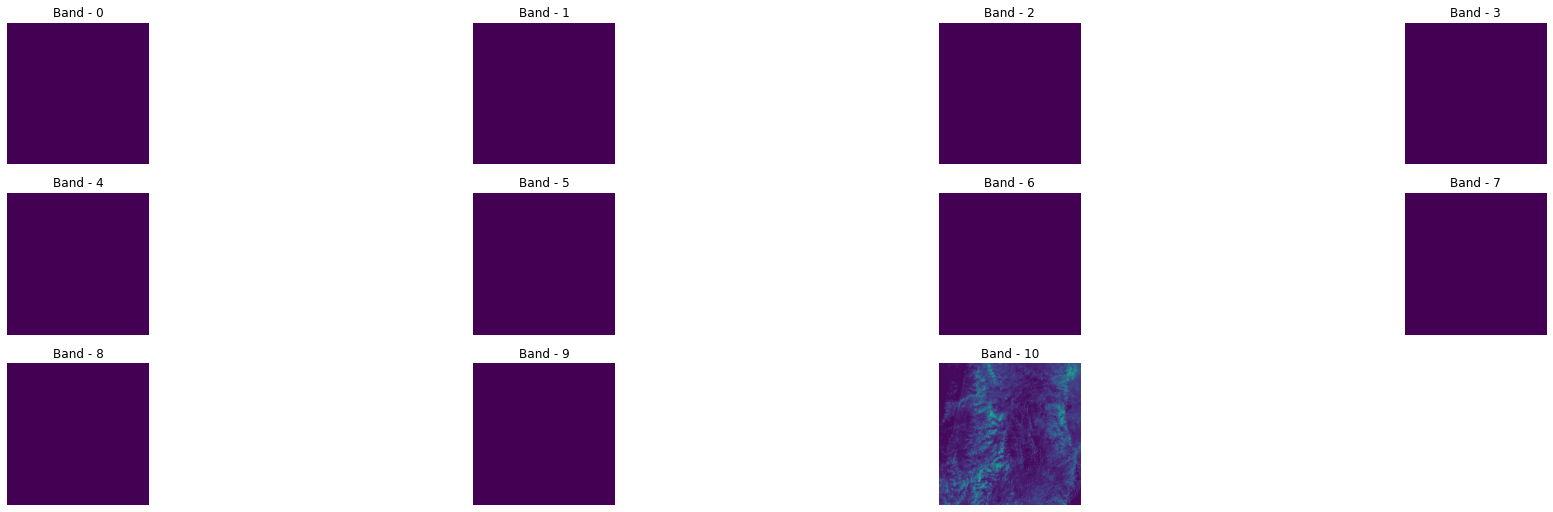

In [ ]:
# ran now
year = 2001
src = rasterio.open('/data/philippines/corrected/{}_resampled.tif'.format(year))
X = np.asarray(src.read())
print(f"Nan check : {np.any(np.isnan(X))}")
print(X.shape)

# catch
fig = plt.figure(figsize = (32, 12))
for i in range(0, 11):
  fig.add_subplot(4, 4, i+1)
  plt.imshow(X[i,:,:], vmin=np.min(X[i,:,:]), vmax=np.max(X[i,:,:]))
  plt.axis('off')
  plt.title(f'Band - {i}')
del X
src.close()

In [ ]:
year = 2007
src = rasterio.open('/data/philippines/corrected/{}_resampled.tif'.format(year))
X = np.asarray(src.read())
print(X.shape)
fig = plt.figure(figsize = (32, 12))
for i in range(0, 11):
  fig.add_subplot(4, 4, i+1)
  plt.imshow(X[i,:,:], vmin=np.min(X[i,:,:]), vmax=np.max(X[i,:,:]))
  plt.axis('off')
  plt.title(f'Band - {i}')
del X
src.close()

#PCA

In [ ]:
import rasterio
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

def extract_pixels(path):
  src = rasterio.open(path)
  print(path.split('/')[-1][:4])
  X = src.read()
  # print(X.shape)
  # X = X[0:11]
  num_channels = X.shape[0]
  #num_channels = num_channels - 4
  # print(X.shape)
  q = X.swapaxes(0, 2)
  del X
  # print(q.shape)
  p = q.reshape(-1, num_channels)
  # print(p.shape)
  del q
  df = pd.DataFrame(p)
  del p
  # print(df.shape)
  # df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= ["band{:02d}".format(i) for i in range(1, 1+num_channels)]
  file_name = "dataset_11bands" + path + ".csv"
  # df.to_csv(file_name)
  
  print("Completed csv creation")
  return df, file_name

import glob
file_list = glob.glob('/data/philippines/corrected/*_resampled.tif')
file_list.sort()
print(file_list)

#X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#X_scaled = X_std * (max - min) + min


# code to find min and max. run once and write values.
min, max = np.zeros(11), np.zeros(11)
min.fill(np.inf)
max.fill(-np.inf)

for year in range(2001, 2021):
  print(f"{year = }")
  df, f_name_ = extract_pixels(f'/data/philippines/corrected/{year}_resampled.tif')
  min_ = np.array(df.min())
  max_ = np.array(df.max())
  if(year == 1990):
    print(f"Shape of min : {min_.shape}, max : {max_.shape}")
  min = np.concatenate((min.reshape(1,-1), min_.reshape(1,-1)))
  max = np.concatenate((max.reshape(1,-1), max_.reshape(1,-1)))
  min = np.min(min, axis = 0)
  max = np.max(max, axis = 0)

  # del df, min_, max_

print(f"{min = }, {max = }")

def normalise(df):
  for k in range(df.shape[1]):
      df.iloc[:, k] = -1 + 2*((df.iloc[:, k] - min[k])/(max[k] - min[k]))
  return df

# min = array([-2.9809494, -2.9809494, -2.9809494, -2.9809494, -2.9809494,
#        -2.9809494, -2.9809494, -2.9809494, -2.9809494, -2.9809494,
#        -2.9809494])
# max = array([66.17165375, 66.17165375, 66.17165375, 66.17165375, 66.17165375,
#        66.17165375, 66.17165375, 66.17165375, 66.17165375, 66.17165375,
#        66.17165375])

['/data/philippines/corrected/2000_resampled.tif', '/data/philippines/corrected/2001_resampled.tif', '/data/philippines/corrected/2002_resampled.tif', '/data/philippines/corrected/2003_resampled.tif', '/data/philippines/corrected/2004_resampled.tif', '/data/philippines/corrected/2005_resampled.tif', '/data/philippines/corrected/2006_resampled.tif', '/data/philippines/corrected/2007_resampled.tif', '/data/philippines/corrected/2008_resampled.tif', '/data/philippines/corrected/2009_resampled.tif', '/data/philippines/corrected/2010_resampled.tif', '/data/philippines/corrected/2011_resampled.tif', '/data/philippines/corrected/2012_resampled.tif', '/data/philippines/corrected/2013_resampled.tif', '/data/philippines/corrected/2014_resampled.tif', '/data/philippines/corrected/2015_resampled.tif', '/data/philippines/corrected/2016_resampled.tif', '/data/philippines/corrected/2017_resampled.tif', '/data/philippines/corrected/2018_resampled.tif', '/data/philippines/corrected/2019_resampled.tif',

In [ ]:
#detour to check the values - max and min

# max_df = pd.DataFrame()
# min_df = pd.DataFrame()

# for file in file_list:
#   df, _ = extract_pixels(file)
#   min_df = min_df.append(df.min(), ignore_index=True)  
#   max_df = max_df.append(df.max(), ignore_index=True)

# print(max_df.max())
# print(min_df.max())

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA
from tqdm import tqdm
batch_size = 1000
pca = IncrementalPCA(n_components = 11, batch_size=batch_size, copy=False)
pca_assumed3 = IncrementalPCA(n_components = 3, batch_size=batch_size, copy=False)
for file in file_list:
  df_, file_name = extract_pixels(file)
  counter = 0
  total = 0
  df_ = normalise(df_)
  #break
  for batch in tqdm(range(0, df_.shape[0]-batch_size, batch_size)):
    total+=1
    # try:  
    #   pca.partial_fit(df_[batch:batch+batch_size])
    #   pca_assumed3.partial_fit(df_[batch:batch+batch_size])
    # except:  counter+=1
  pca.partial_fit(df_[df_.shape[0]-batch_size-1:df_.shape[0]])
  pca_assumed3.partial_fit(df_[df_.shape[0]-batch_size-1:df_.shape[0]])
  print(total, counter)
  print("-------------------------------")
print("Completed the work")

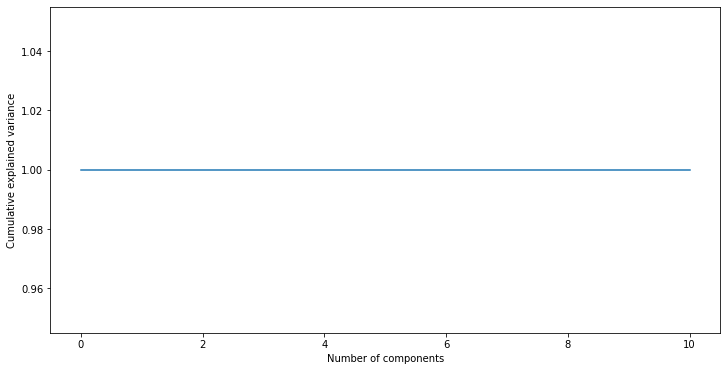

In [ ]:
ev=pca.explained_variance_ratio_
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [ ]:
pca_assumed3.components_

array([[ 0.30151134,  0.30151134,  0.30151134,  0.30151134,  0.30151134,
         0.30151134,  0.30151134,  0.30151134,  0.30151134,  0.30151134,
         0.30151134],
       [-0.53303028, -0.08876468, -0.07621276, -0.07621276, -0.07621276,
        -0.07621276, -0.07621276, -0.07621276, -0.07621276,  0.57764213,
         0.57764213],
       [ 0.7768628 , -0.34469638, -0.13832953, -0.13832953, -0.13832953,
        -0.13832953, -0.13832953, -0.13832953, -0.13832953,  0.26807013,
         0.26807013]])

# Generating Shards

In [ ]:
PICTURE_SIZE = 32

In [ ]:
import random
import tables
suffix = ['_000', '_001', '_002', '_003', '_004', '_005', '_006', '_007', '_008', '_009', '_010', '_011', '_012', '_013', '_014']
X_file = tables.open_file('/data/philippines/h5/X.h5', mode='r')
y_file = tables.open_file('/data/philippines/h5/y.h5', mode='r')
size_of_shard = X_file.root.data.shape[0]//15
indices = list(range(X_file.root.data.shape[0]))
num_channels = 11
look_back = 5
picture_size = PICTURE_SIZE
random.shuffle(indices)
for i in range(15):

  filename_X = '/data/philippines/h5/X'+suffix[i]+'.h5'
  filename_y = '/data/philippines/h5/y'+suffix[i]+'.h5'
  
  f_X = tables.open_file(filename_X, mode='w')
  f_y = tables.open_file(filename_y, mode='w')
  atom_X = tables.Float64Atom()
  array_X = f_X.create_earray(f_X.root, 'data', atom_X, (0, look_back, num_channels, picture_size, picture_size))
  atom_y = tables.Int8Atom()
  array_y = f_y.create_earray(f_y.root, 'data', atom_y, (0, 1, picture_size, picture_size))
  f_X.close()
  f_y.close()
  f_X = tables.open_file(filename_X, mode='a')
  f_y = tables.open_file(filename_y, mode='a')
  for j in range(size_of_shard):
    print("Shifting ", indices[i*size_of_shard + j], " to shard ", suffix[i])
    f_X.root.data.append(X_file.root.data[indices[i*size_of_shard + j]:indices[i*size_of_shard + j]+1, :, :, :, :])
    f_y.root.data.append(y_file.root.data[indices[i*size_of_shard + j]:indices[i*size_of_shard + j]+1, :, :, :])
  f_X.close()
  f_y.close()

Streaming output truncated to the last 5000 lines.
Shifting  4717  to shard  _008
Shifting  6702  to shard  _008
Shifting  8283  to shard  _008
Shifting  10279  to shard  _008
Shifting  9690  to shard  _008
Shifting  1015  to shard  _008
Shifting  4144  to shard  _008
Shifting  1046  to shard  _008
Shifting  4947  to shard  _008
Shifting  9957  to shard  _008
Shifting  10014  to shard  _008
Shifting  8818  to shard  _008
Shifting  7566  to shard  _008
Shifting  2688  to shard  _008
Shifting  11003  to shard  _008
Shifting  10762  to shard  _008
Shifting  11039  to shard  _008
Shifting  6569  to shard  _008
Shifting  7954  to shard  _008
Shifting  6772  to shard  _008
Shifting  3837  to shard  _008
Shifting  2139  to shard  _008
Shifting  10864  to shard  _008
Shifting  2902  to shard  _008
Shifting  1110  to shard  _008
Shifting  10898  to shard  _008
Shifting  9353  to shard  _008
Shifting  3069  to shard  _008
Shifting  9506  to shard  _008
Shifting  3032  to shard  _008
Shifting  96

# Applying PCA to shards

In [ ]:
!pip install rasterio
import rasterio
import rasterio.plot
from rasterio.windows import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tables
project_id = 'omega-granite-294710'
!gcloud config set project {project_id}
!gsutil ls

import tqdm
# to process large h5 file
# use values from above to get proper scaling. Use these values in normalisation everywhere
# min = [305.949615, 220.965012, 143.591522, 162.080719, 134.795334, 2802.544678, 118.325638, 152.126511, -0.387340, 66.813599, -0.275436]
# max = [22073.414062, 21508.564453, 21490.376953, 21065.839844, 19574.505859, 3798.636963, 8382.725586, 784.440063, 45.683414, 235.566147, 77.264893]

class Transformer():
  def __init__(self, batch_size):
    tables.file._open_files.close_all()
    self.batch_size = batch_size
    self.num_channels_target = 3
    self.num_channels_initial = 11
    self.look_back = 5
    self.picture_size = PICTURE_SIZE
    self.shard_id = 0
    self.suffix = ['_000', '_001', '_002', '_003', '_004', '_005', '_006', '_007', '_008', '_009', '_010', '_011', '_012', '_013', '_014'] 
    # splitting the entire h5 data into 15 cohorts for faster i/o and preventing memory error
    X = tables.open_file('/data/philippines/h5/X'+self.suffix[self.shard_id]+'.h5', mode='r')
    self.size_of_shard = X.root.data.shape[0]
    self.num_of_batches_per_shard = int(np.ceil(self.size_of_shard / self.batch_size))
    self.x = self.x_corrected = 0

  def __len__(self):
    return self.num_of_batches_per_shard*len(self.suffix)
  
  def __initialiseFile__(self, shard_id):
    self.x = tables.open_file('/data/philippines/h5/X'+self.suffix[shard_id]+'.h5', mode='r')
    self.x_corrected = tables.open_file('/data/philippines/h5/X'+self.suffix[shard_id]+'_afterPCA.h5', mode='w')
    atom_X = tables.Float64Atom()
    array_X = self.x_corrected.create_earray(self.x_corrected.root, 'data', atom_X, (0, self.look_back, self.num_channels_target, self.picture_size, self.picture_size))
    self.x_corrected.close()
    self.x_corrected = tables.open_file('/data/philippines/h5/X'+self.suffix[shard_id]+'_afterPCA.h5', mode='a')

  def __closeFiles__(self):
    tables.file._open_files.close_all()

  def __getInfo__(self):
    idx_points = np.arange(0, self.size_of_shard+self.batch_size, self.batch_size)
    for idx in tqdm.tqdm(range(len(idx_points)-1)):
      batch_x = self.x.root.data[idx_points[idx]:idx_points[idx]+self.batch_size]   
      for k in range(batch_x.shape[2]):
        print(k, batch_x[:, :, k, :, :].max(), batch_x[:, :, k, :, :].min())
      break
    return

  def __transformBatch__(self, batch_x):
    #print("Batch Shape just after input: ", batch_x.shape)

    for k in range(batch_x.shape[2]):
      batch_x[:, :, k, :, :] = -1 + 2*((batch_x[:, :, k, :, :] - min[k])/(max[k] - min[k]))
    
    # array([[ 6.11790721e-01,  4.76414366e-01,  5.26036601e-01,
    #      2.66004028e-01,  1.60198412e-01, -4.28105121e-04,
    #      8.99710037e-02,  8.34101676e-02, -1.03113324e-02,
    #      9.19616458e-02,  4.46071403e-02],
    #    [-5.98489600e-02, -1.48297420e-02, -2.10428122e-02,
    #     -3.57500969e-02, -3.70128478e-02,  2.86820823e-01,
    #      4.84994600e-02,  9.42925142e-01, -3.65573720e-02,
    #     -1.32970343e-01, -1.90683426e-02],
    #    [-7.28890288e-02, -3.36034648e-02, -3.32579488e-02,
    #      3.64501476e-03,  1.31231863e-02,  3.81129667e-02,
    #      1.22856580e-02,  1.14284486e-01,  6.40028424e-01,
    #      7.52557943e-01,  4.02750537e-02]])
    
    # transform = np.array([[ 4.57739675e-01,  3.87892359e-01,  4.12756607e-01,
    #      2.48268526e-01,  1.35187129e-01, -6.51380571e-02,
    #      1.91935455e-01, -1.74104199e-02, -9.50105267e-03,
    #      5.79620330e-01,  1.10895289e-01],
    #    [-2.28906565e-01, -2.89892452e-01, -2.98421960e-01,
    #     -1.42718906e-01,  1.50181455e-02,  4.85542889e-03,
    #      7.30409685e-02, -2.05981871e-03, -5.75793478e-01,
    #      6.34623615e-01, -1.19441163e-01],
    #    [-2.01508254e-01, -1.50465955e-01, -1.47333980e-01,
    #     -1.25476645e-01, -4.12752043e-02, -2.88795965e-04,
    #     -3.53168593e-02,  1.97773196e-01,  7.92902846e-01,
    #      4.72558747e-01, -7.23242267e-02]])
    
    transform = np.array([[ 1.78539113e-03,  1.82703767e-03,  1.82806318e-03,
         1.89614697e-03,  2.06711616e-03,  1.67934251e-02,
         4.80973636e-03,  5.38290264e-02,  8.25024359e-01,
         2.29594586e-01,  5.13225760e-01],
       [-1.06764326e-03, -1.09254741e-03, -1.09316065e-03,
        -1.13387397e-03, -1.23611157e-03, -1.00422741e-02,
        -2.87616675e-03, -3.21891356e-02, -4.93355030e-01,
        -1.37294909e-01,  8.58253645e-01],
       [-4.11413842e-01, -4.95626416e-01,  5.03499681e-01,
         7.90104974e-02,  2.60548463e-01,  2.07624769e-01,
        -1.63856640e-01, -1.74370882e-02, -1.17939001e-01,
         4.16271924e-01, -7.21644966e-16]])

   
    transformed_batch = np.zeros((1,5,3,PICTURE_SIZE,PICTURE_SIZE))
    for xx in range(batch_x.shape[0]):
      b = batch_x[xx]
      temp_storage = np.zeros((5,3,PICTURE_SIZE,PICTURE_SIZE))
      for i in range(b.shape[0]):
        c = b[i]
        d = np.dot(c.swapaxes(0, 2).reshape(-1, 11), transform.T).reshape((-1, PICTURE_SIZE, 3)).swapaxes(0, 2)
        temp_storage[i] = d
      transformed_batch[xx] = temp_storage
    return transformed_batch

  def __transformationAndAppend__(self):
    idx_points = np.arange(0, self.size_of_shard+self.batch_size, self.batch_size)
    #print(idx_points)
    for idx in tqdm.tqdm(range(len(idx_points)-1)):
      #print("Working from: ", idx_points[idx], idx_points[idx]+self.batch_size)
      batch = self.x.root.data[idx_points[idx]:idx_points[idx]+self.batch_size]
      transformedBatch = self.__transformBatch__(batch)
      #print("Batch Shape: ", batch.shape, " | Transformed Batch Shape: ", transformedBatch.shape)
      self.x_corrected.root.data.append(transformedBatch)

In [ ]:
TransformerClass = Transformer(1)
for i in range(len(TransformerClass.suffix)):
  print("Starting file: ", i)
  TransformerClass.__initialiseFile__(i)
  TransformerClass.__transformationAndAppend__()
  TransformerClass.__closeFiles__()

Closing remaining open files:/data/philippines/h5/X.h5...done/data/philippines/h5/y.h5...done


Starting file:  0


100%|██████████| 742/742 [00:00<00:00, 914.92it/s]
Closing remaining open files:/data/philippines/h5/X_000.h5...done/data/philippines/h5/X_000_afterPCA.h5...done/data/philippines/h5/X_000.h5...done


Starting file:  1


100%|██████████| 742/742 [00:00<00:00, 1097.13it/s]
Closing remaining open files:/data/philippines/h5/X_001.h5...done/data/philippines/h5/X_001_afterPCA.h5...done


Starting file:  2


100%|██████████| 742/742 [00:00<00:00, 1074.39it/s]
Closing remaining open files:/data/philippines/h5/X_002_afterPCA.h5...done/data/philippines/h5/X_002.h5...done


Starting file:  3


100%|██████████| 742/742 [00:00<00:00, 1050.01it/s]
Closing remaining open files:/data/philippines/h5/X_003_afterPCA.h5...done/data/philippines/h5/X_003.h5...done


Starting file:  4


100%|██████████| 742/742 [00:00<00:00, 1076.98it/s]
Closing remaining open files:/data/philippines/h5/X_004.h5...done/data/philippines/h5/X_004_afterPCA.h5...done


Starting file:  5


100%|██████████| 742/742 [00:00<00:00, 1073.39it/s]
Closing remaining open files:/data/philippines/h5/X_005_afterPCA.h5...done/data/philippines/h5/X_005.h5...done


Starting file:  6


100%|██████████| 742/742 [00:00<00:00, 1082.33it/s]
Closing remaining open files:/data/philippines/h5/X_006_afterPCA.h5...done/data/philippines/h5/X_006.h5...done


Starting file:  7


100%|██████████| 742/742 [00:00<00:00, 1078.78it/s]
Closing remaining open files:/data/philippines/h5/X_007.h5...done/data/philippines/h5/X_007_afterPCA.h5...done


Starting file:  8


100%|██████████| 742/742 [00:00<00:00, 1089.12it/s]
Closing remaining open files:/data/philippines/h5/X_008_afterPCA.h5...done/data/philippines/h5/X_008.h5...done


Starting file:  9


100%|██████████| 742/742 [00:00<00:00, 1082.30it/s]
Closing remaining open files:/data/philippines/h5/X_009.h5...done/data/philippines/h5/X_009_afterPCA.h5...done


Starting file:  10


100%|██████████| 742/742 [00:00<00:00, 1074.72it/s]
Closing remaining open files:/data/philippines/h5/X_010.h5...done/data/philippines/h5/X_010_afterPCA.h5...done


Starting file:  11


100%|██████████| 742/742 [00:00<00:00, 1091.63it/s]
Closing remaining open files:/data/philippines/h5/X_011_afterPCA.h5...done/data/philippines/h5/X_011.h5...done


Starting file:  12


100%|██████████| 742/742 [00:00<00:00, 1052.83it/s]
Closing remaining open files:/data/philippines/h5/X_012_afterPCA.h5...done/data/philippines/h5/X_012.h5...done


Starting file:  13


100%|██████████| 742/742 [00:00<00:00, 1071.21it/s]
Closing remaining open files:/data/philippines/h5/X_013_afterPCA.h5...done/data/philippines/h5/X_013.h5...done


Starting file:  14


100%|██████████| 742/742 [00:00<00:00, 982.13it/s]
Closing remaining open files:/data/philippines/h5/X_014_afterPCA.h5...done/data/philippines/h5/X_014.h5...done


# Model Training

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install tables
import tables
import tensorflow as tf
from tensorflow import *
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.models import load_model
from tensorflow.keras.utils import Sequence
from keras import Model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"Gpu name : {tf.test.gpu_device_name()}")

Num GPUs Available:  1
Gpu name : /device:GPU:0


In [ ]:
# to process large h5 files
# use values from above to get proper scaling. Use these values in normalisation everywhere

class DeforDataSequence(Sequence):
  
  def __init__(self, batch_size, mode, targets = 'regression'):
    self.batch_size = batch_size
    self.mode = mode
    self.shards = 0
    self.folder = 'h5'
    self.targets = targets
    if self.mode == 'train':
      self.suffix = ['_000', '_001', '_002', '_003', '_004', '_005', '_006', '_007', '_008', '_009', '_010'] # splitting the entire h5 data into 15 cohorts for faster i/o and preventing memory error
      #self.suffix = ['_000']
    elif self.mode == 'test':
      self.suffix = ['_011', '_012', '_013', '_014']
    elif self.mode == 'new_patch':
      self.suffix = ['_000', '_001', '_002', '_003', '_004', '_005', '_006', '_007', '_008', '_009', '_010', '_011', '_012', '_013', '_014']
      self.folder = 'h5_patch2'
    self.x = tables.open_file('/data/philippines/'+self.folder+'/X'+self.suffix[self.shards]+'_afterPCA.h5', mode='r')
    self.y = tables.open_file('/data/philippines/'+self.folder+'/y'+self.suffix[self.shards]+'.h5', mode='r')
    self.size_of_shard = self.x.root.data.shape[0]
    self.num_of_batches_per_shard = int(np.ceil(self.size_of_shard / self.batch_size))

  def __len__(self):
    return self.num_of_batches_per_shard*len(self.suffix)
  
  def __getBatchForVisualisationX__(self, idx, item_ = "None"):
     if item_ is "None":
       item_ = self.suffix[self.shards]
     self.x = tables.open_file('/data/philippines/'+self.folder+'/X'+item_+'_afterPCA.h5', mode='r')
     batch_x = self.x.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]
     self.x.close()
     return batch_x

  def __getBatchForVisualisationY__(self, idx, item_ = "None"):
     if item_ is "None":
       item_ = self.suffix[self.shards]
     self.y = tables.open_file('/data/philippines/'+self.folder+'/y'+item_+'.h5', mode='r')
     batch_y = self.y.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]
     self.y.close()
     return batch_y

  def __getitem__(self, idx):
    batch_x = self.x.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]
    batch_y = self.y.root.data[(idx-self.shards*self.num_of_batches_per_shard)*self.batch_size : (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size]

    # handle nans in batch_x
    # batch_x = tf.where(tf.math.is_nan(batch_x), tf.fill(batch_x.shape, batch_x.mean()) , batch_x)


    # batch_y = batch_y/100.0
    batch_y = np.where(batch_y<0.0, 0.0, batch_y)

    if self.targets == 'binary':
    #   # batch_y = np.where(batch_y > 0.635, 1, 0).astype(int) #experiment - converting binary
      batch_y = np.where(batch_y > 0.6, 1, 0).astype(int) #experiment - converting binary
    
    batch_y = tf.cast(batch_y, "float32")

    if (idx-self.shards*self.num_of_batches_per_shard + 1)*self.batch_size >= self.size_of_shard:
      self.x.close()
      self.y.close()
      self.shards = (self.shards+1)%len(self.suffix)
      self.x = tables.open_file('/data/philippines/'+self.folder+'/X'+self.suffix[self.shards]+'_afterPCA.h5', mode='r')
      self.y = tables.open_file('/data/philippines/'+self.folder+'/y'+self.suffix[self.shards]+'.h5', mode='r')
    
    # print(f"{batch_x.shape = }, {batch_y.shape = }")
    return batch_x, batch_y

<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-2-1dadaa5696bd>:29: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if item_ is "None":
<ipython-input-2-1dadaa5696bd>:37: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if item_ is "None":


In [ ]:
#@title Hyperparams
# Do NOT modify code
id = "0010_resampled_binary" #@param {type:"string"}
loss_type = 'binary_crossentropy' #@param ["weighted_binary_crossentropy", "binary_crossentropy", "hinge", "mean_squared_error"]
deforested_loss_weight = 100.0 #@param {type:"number"}
optimizer = 'adam' #@param ["adam", "adagrad", "adadelta"]
learning_rate =  0.005 #@param {type:"number"}
batch_size =  16#@param {type:"integer"}
epochs =  100 #@param {type:"integer"}

In [ ]:
from tensorflow.keras.utils import plot_model
PICTURE_SIZE = 32
init = tf.keras.initializers.GlorotNormal()
def create_model():
  return keras.Sequential(
      [ 
      tf.keras.Input(shape=(5, 3, PICTURE_SIZE, PICTURE_SIZE)),
      tf.keras.layers.ConvLSTM2D(filters = 20, kernel_size = (3,3), padding = 'same', kernel_initializer=init, activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 15, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 12, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 10, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 6, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 3, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 2, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.ConvLSTM2D(filters = 1, kernel_size = (3,3), padding = 'same', activation='sigmoid', data_format = 'channels_first'),
      # tf.keras.layers.BatchNormalization(),
      # tf.keras.layers.Permute((2,3,1)),
      # tf.keras.layers.Conv2D(filters = 1, kernel_size = (3,3), padding='same', activation='sigmoid', data_format= 'channels_last'),
      # tf.keras.layers.Permute((3,1,2)), 
      ]
  )

class module(Model):
  def __init__(self, num_filters):
    super(module, self).__init__()
    self.counter = 0
    self.num_filters = num_filters
    self.nn_layers = keras.Sequential([tf.keras.layers.ConvLSTM2D(filters = self.num_filters, kernel_size = (3,3), padding = 'same', activation='relu', return_sequences = True, data_format = 'channels_first'),
      tf.keras.layers.BatchNormalization()])
    
  def call(self, x):
    self.counter += 1
    x = self.nn_layers(x)
    # fill here 
    if(self.counter % 100 == 0):
      norm = tf.norm(self.nn_layers.layers[0].get_weights())
      print(f"counter : {self.counter}, weight norm = {norm}")

    # print(f"{tf.math.reduce_any(tf.math.is_nan(x)) = }")
    if(tf.math.reduce_any(tf.math.is_nan(x))):
      print(f"Nan entry after pass from layer {self.num_filters = }")

    return x

class prediction_model(Model):
  def __init__(self):
    super(prediction_model, self).__init__()
    self.model = keras.Sequential([ 
      tf.keras.Input(shape=(5, 3, PICTURE_SIZE, PICTURE_SIZE)),
      module(20),
      module(15),
      module(12),
      module(10),
      module(8),
      module(6),
      module(4),
      module(3),
      module(2),
      tf.keras.layers.ConvLSTM2D(filters = 1, kernel_size = (3,3), padding = 'same', activation='sigmoid', data_format = 'channels_first')

      # tf.keras.layers.BatchNormalization(),
      # tf.keras.layers.Permute((2,3,1)),
      # tf.keras.layers.Conv2D(filters = 1, kernel_size = (3,3), padding='same', activation='sigmoid', data_format= 'channels_last'),
      # tf.keras.layers.Permute((3,1,2)), 
      ])
  
  def call(self, inputs):
    x = self.model(inputs)
    # fill here 
    return x
  

model = create_model()
# model = prediction_model()
image = plot_model(model, show_shapes=True)
# model.summary()

In [ ]:
# print(model.model.layers[2].name)
for layer in model.model.layers:
  print(type(layer))
# print(len(model.model.layers[4].get_weights()))

In [ ]:
def weighted_binary_cross_entropy(weights: dict, from_logits: bool = False):
    def weighted_cross_entropy_fn(y_true, y_pred):
        tf_y_true = tf.cast(y_true, dtype=y_pred.dtype)
        tf_y_pred = tf.cast(y_pred, dtype=y_pred.dtype)
        weights_v = tf.where(tf.equal(tf_y_true, 1), deforested_loss_weight, 1.0)    #weights_v = tf.where(tf.equal(tf_y_true, 1), weights[1], weights[0])
        ce = K.binary_crossentropy(tf_y_true, tf_y_pred, from_logits=from_logits)
        loss = K.mean(tf.multiply(ce, weights_v))
        return loss
    return weighted_cross_entropy_fn

METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
]

loss_arg = None
if loss_type == 'weighted_binary_crossentropy':
  loss_arg = weighted_binary_cross_entropy({})
elif loss_type == 'binary_crossentropy':
  loss_arg = tf.keras.losses.BinaryCrossentropy()
elif loss_type == 'hinge':
  loss_arg = tf.keras.losses.Hinge()
elif loss_type == 'mean_squared_error':
  loss_arg = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
elif loss_type == 'mean_absolute_error':
  loss_arg = tf.keras.losses.MeanAbsoluteError()

optimizer_arg = None
if optimizer == 'adam':
  optimizer_arg = keras.optimizers.Adam(learning_rate=learning_rate)
elif optimizer == 'adagrad':
  optimizer_arg = keras.optimizers.Adagrad(learning_rate=learning_rate)
elif optimizer == 'adadelta':
  optimizer_arg = keras.optimizers.Adadelta(learning_rate=learning_rate)

model_path = '/data/philippines/model/model_' + id 

## Training

In [ ]:
for x,y in data_sequence:
  print(tf.reduce_any(tf.math.is_nan(y)))
  # if(tf.reduce_any(tf.math.is_nan(y)) == 1):
  #   print("Nan Exists")

In [ ]:
# catch
del model

In [ ]:
model = create_model()
# model = prediction_model()
model.compile(loss=loss_arg, optimizer=optimizer_arg, metrics=METRICS)
model_checkpoint_callback = ModelCheckpoint(filepath=model_path)

#model
path = # catch
csv_logger = CSVLogger('/data/philippines/log/model_'+id+'.log', append=True, separator=';')
tensorboard = TensorBoard(log_dir='/data/philippines/log/model_'+id)
# sys.stdout = open('/dev/stdout', 'w')

In [ ]:
data_sequence = DeforDataSequence(8, 'train', 'binary')
# data_sequence = DeforDataSequence(8, 'train', 'mean_squared_error')
model.fit(x = data_sequence, epochs = epochs, verbose = 2, shuffle=False, callbacks=[model_checkpoint_callback, csv_logger, tensorboard])

In [ ]:
model.save(path)

In [ ]:
print(tf.norm(model.layers[0].get_weights()[0]))

## Define explicit training pipeline

In [ ]:
# for item in data_sequence:
#   print(len(item))

id = "0010_resampled_binary" #@param {type:"string"}
loss_type = 'binary_crossentropy' #@param ["weighted_binary_crossentropy", "binary_crossentropy", "hinge", "mean_squared_error"]
deforested_loss_weight = 100.0 #@param {type:"number"}
optimizer = 'adam' #@param ["adam", "adagrad", "adadelta"]
learning_rate =  0.005 #@param {type:"number"}
batch_size =  16#@param {type:"integer"}
epochs =  100 #@param {type:"integer"}

# initialize optimzer, dataloader
data_sequence = DeforDataSequence(batch_size, 'train', 'binary') # dataloader

# loop over dataset
count = 0
avg=0
for x, y in data_sequence:  
  # update loss
  count += 1
  avg += (1/count) * (y.mean() - avg)

print(avg)

    # do backprop
    # clip grads (optional)

    # take gradient step

# print(len(data_sequence))
# for x, y in data_sequence:
#   print(f"{x.shape = }, {y.shape = }")

0.8378909350716494


## Testing

### Model 006 - Binary target, Normalization Corrected PCA - All training shards passed, train auc = 0.78, epochs = 50

In [ ]:
id = "0006_resampled_binary"
model_path = '/data/philippines/model/model_' + id 
model = keras.models.load_model(model_path)
data_sequence = DeforDataSequence(8, 'test')
result = model.evaluate(x = data_sequence, verbose = 0)
result = {out: result[i] for i, out in enumerate(model.metrics_names)}
test_results = pd.DataFrame(result, index = [0])

test_results.to_csv('/data/philippines/results/model_'+id+'.csv')
print(test_results)

       loss        tp       fp      tn      fn  accuracy  precision    recall  \
0  0.312102  492198.0  55357.0  3848.0  5653.0  0.890478   0.898901  0.988645   

        auc  
0  0.731625  
